In [1]:
import time

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
def imshow(image, cmap=plt.cm.gray):
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

In [4]:
import numpy as np

In [5]:
from pyspark import SparkConf
from pyspark import SparkContext

In [6]:
sc = SparkContext('yarn-client', 'spark-numbapro')

In [7]:
def load_images(image):
    from PIL import Image
    import numpy as np
    from StringIO import StringIO
    img = Image.open(StringIO(image[1]))
    rgb = np.asarray(img, dtype=np.uint8)
    return np.sum(rgb.astype(np.int), axis=2) / 3

In [8]:
images = sc.binaryFiles("hdfs:///tmp/dogs-cats/dog.[0-9].jpg").map(load_images)

## CPU

In [9]:
def cpu_convolution(image):
    from scipy.signal import fftconvolve
    laplacian_pts = '''
    -1 -1 -1
    -1 5 -1 
    -1 -1 -1 
    '''.split()
    laplacian = np.array(laplacian_pts, dtype=np.float32).reshape(3, 3)
    cvimage_cpu = fftconvolve(image, laplacian, mode='same')
    return cvimage_cpu

In [10]:
cpu_ret = images.map(cpu_convolution)

In [11]:
start_time = time.time()
cpu_ret.collect()
cpu_time = time.time() - start_time
cpu_time

6.5673229694366455

## GPU

In [12]:
def gpu_convolution(image):
    import numpy as np
    from numbapro import cuda
    from numbapro.cudalib import cufft

    def best_grid_size(size, tpb):
        bpg = np.ceil(np.array(size, dtype=np.float) / tpb).astype(np.int).tolist()
        return tuple(bpg)

    if hasattr(cuda, 'mult_inplace'):
        mult_inplace = cuda.mult_inplace
    else:
        @cuda.jit('void(complex64[:,:], complex64[:,:])')
        def mult_inplace(img, resp):
            i, j = cuda.grid(2)
            if j < img.shape[0] and i < img.shape[1]:
                img[j, i] *= resp[j, i]
        cuda.mult_inplace = mult_inplace
    
    laplacian_pts = '''
    -1 -1 -1
    -1 5 -1 
    -1 -1 -1 
    '''.split()
    laplacian = np.array(laplacian_pts, dtype=np.float32).reshape(3, 3)

    threadperblock = 32, 8
    blockpergrid = best_grid_size(tuple(reversed(image.shape)), threadperblock)

    response = np.zeros_like(image)
    response[:3, :3] = laplacian

    image_complex = image.astype(np.complex64)
    response_complex = response.astype(np.complex64)

    stream1 = cuda.stream()
    stream2 = cuda.stream()

    fftplan1 = cufft.FFTPlan(shape=image.shape, itype=np.complex64,
                             otype=np.complex64, stream=stream1)
    fftplan2 = cufft.FFTPlan(shape=image.shape, itype=np.complex64,
                             otype=np.complex64, stream=stream2)

    # pagelock memory
    with cuda.pinned(image_complex, response_complex):
        # We can overlap the transfer of response_complex with the forward FFT
        # on image_complex.
        d_image_complex = cuda.to_device(image_complex, stream=stream1)
        d_response_complex = cuda.to_device(response_complex, stream=stream2)

        fftplan1.forward(d_image_complex, out=d_image_complex)
        fftplan2.forward(d_response_complex, out=d_response_complex)

        stream2.synchronize()

        mult_inplace[blockpergrid, threadperblock, stream1](d_image_complex,
                                                            d_response_complex)
        fftplan1.inverse(d_image_complex, out=d_image_complex)

        # implicitly synchronizes the streams
        cvimage_gpu = d_image_complex.copy_to_host().real / np.prod(image.shape)
        
    return cvimage_gpu

In [13]:
gpu_ret = images.map(gpu_convolution)

In [14]:
start_time = time.time()
gpu_ret.collect()
gpu_time = time.time() - start_time
gpu_time

4.819637060165405

In [15]:
print 'CPU: %s' % cpu_time
print 'GPU: %s' % gpu_time

CPU: 6.56732296944
GPU: 4.81963706017


## Images

In [16]:
images_ = images.take(10)

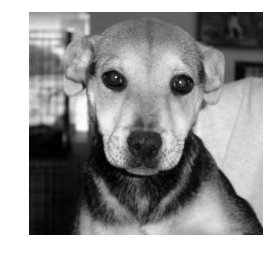

In [17]:
imshow(images_[4])

In [18]:
cpu_images = cpu_ret.take(10)

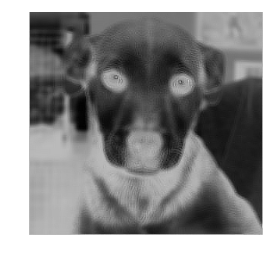

In [19]:
imshow(cpu_images[4])

In [20]:
gpu_images = gpu_ret.take(10)

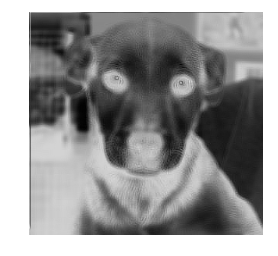

In [21]:
imshow(gpu_images[4])

## More images

In [22]:
images = sc.binaryFiles("hdfs:///tmp/dogs-cats/dog.[0-4][0-9][0-9].jpg").map(load_images)

In [23]:
cpu_ret = images.map(cpu_convolution)

In [24]:
start_time = time.time()
cpu_ret.collect()
cpu_time = time.time() - start_time
cpu_time

20.783078908920288

In [25]:
gpu_ret = images.map(gpu_convolution)

In [26]:
start_time = time.time()
gpu_ret.collect()
gpu_time = time.time() - start_time
gpu_time

18.93306303024292

In [27]:
print 'CPU: %s' % cpu_time
print 'GPU: %s' % gpu_time

CPU: 20.7830789089
GPU: 18.9330630302
